# Первый (промежуточный) проект e-learning
******

## Содержание

- [Постановка задач](#tasks)
- [Загрузка необходимых библиотек](#libs)
- [Загрузка данных](#data)
- [Предварительный обзор данных](#preliminary)
	- [assesments](#assesments)
	- [courses](#courses)
	- [students_assessments](#students_assessments)
	- [students_registration](#students_registration)
- [Решение поставленных задач](#tasks)
- [Задание 1](#task1)
- [Задание 2](#task2)
- [Задание 3](#task3)
- [Задание 4](#task4)
- [Задание 5](#task5)
- [Задание 6](#task6)
	- [Построение общей таблицы с данными о студентах. Предварительный анализ данных](#main_table)
	- [Проект разбиения по кластерам](#RFM_clasters)
	- [Определение параметров для разбиения по параметру M (оценки на экзаменах)](#cat_M)
	- [Определение параметров для разбиения по параметру F (завершаемость)](#cat_F)
	- [Определение параметров для разбиения по параметру R (среднее время сдачи одного экзамена)](#cat_R)
	- [Дополнительное исследование](#additional_research)
	- [Результат](#result)
- [Дополнительное исследование 2](#additional_research2)
- [Дополнительное исследование 3](#additional_research3)

# Постановка задач  <a class="anchor" id="tasks"></a>

Необходимо проанализировать завершенные уроки в системе онлайн-образования и ответить на следующие вопросы:

1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене).

2. Выявить самый сложный и самый простой экзамены: найти курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*.

3. По каждому предмету определить средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом).

4. Выявить самые популярные курсы (ТОП-3) по количеству регистраций на них. А также курсы с самым большим оттоком (ТОП-3).

5. Написать функцию на python, позволяющую строить когортный (семестровый) анализ. В период с начала 2013 по конец 2014 выявить семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.

6. Построить адаптированные под задачу обучения RFM-кластеры студентов. Где R — среднее время сдачи одного экзамена, F — завершаемость\* курсов, M — среднее количество баллов, получаемое за экзамен. Подробно описать, как создавал кластеры. Примерное описание подхода можно найти тут.

\*завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен

# Загрузка необходимых библиотек <a class="anchor" id="libs"></a>

In [88]:
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных <a class="anchor" id="data"></a>

In [89]:
assessments = pd.read_csv('./assessments.csv')
courses = pd.read_csv('./courses.csv')
students_assessments = pd.read_csv('./studentAssessment.csv')
students_registration = pd.read_csv('./studentRegistration.csv')

# Предварительный обзор данных <a class="anchor" id="preliminary"></a>

## assesments <a class="anchor" id="assesments"></a>

Информация об оценках по курсам. Обычно в ходе прохождения курса проводится несколько контрольных работ, за которыми следует заключительный экзамен.

- ```code_module``` — идентификационный код модуля (предмета, курса по предмету),
- ```code_presentation``` — идентификационный код презентации -- если по-русски, то это код семестра,
- ```id_assessment``` — идентификационный номер контрольной работы,
- ```assessment_type``` — тип оценки. Существуют три типа оценивания: оценка преподавателя (TMA), компьютерная оценка (СМА), экзамен по курсу (Exam),
- ```date``` — информация об окончательной дате сдачи контрольной работы. Рассчитывается как количество дней с момента начала модуля-презентации. Дата начала презентации имеет номер 0 (ноль),
- ```weight``` — вес оценки в %. Обычно экзамены рассматриваются отдельно и имеют вес 100%; сумма всех остальных оценок составляет 100%.

In [90]:
assessments.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


Проверка типов данных:

In [91]:
assessments.dtypes

code_module           object
code_presentation     object
id_assessment          int64
assessment_type       object
date                 float64
weight               float64
dtype: object

Проверка на дубликаты и отсутствующие значения:

In [92]:
import spelling

a0 = assessments.shape[0]
a1 = assessments.shape[1]
a2 = assessments.dropna().shape[0]
a3 = assessments.drop_duplicates().shape[0]

print(a0, spelling.rows_word(a0), "и", a1, spelling.cols_word(a1))
print(a2, spelling.rows_word(a2), "после удаления строк, содержащих NULL")
print(a3, spelling.rows_word(a3), "после удаления дубликатов")

206 строк и 6 колонок
195 строк после удаления строк, содержащих NULL
206 строк после удаления дубликатов


## courses <a class="anchor" id="courses"></a>

Список всех доступных модулей (курсов) и их презентации

- ```code_module``` — идентификационный код модуля (предмета),
- ```code_presentation``` — идентификационный код семестра, в котором проводился курс,
- ```module_presentation_length``` — продолжительность модуля-презентации в днях.

In [93]:
courses.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


Проверка типов данных:

In [94]:
courses.dtypes

code_module                   object
code_presentation             object
module_presentation_length     int64
dtype: object

In [95]:
courses.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


Проверка типов данных:

In [96]:
courses.dtypes

code_module                   object
code_presentation             object
module_presentation_length     int64
dtype: object

Проверка на дубликаты и отсутствующие значения:

In [97]:
a0 = courses.shape[0]
a1 = courses.shape[1]
a2 = courses.dropna().shape[0]
a3 = courses.drop_duplicates().shape[0]

print(a0, spelling.rows_word(a0), "и", a1, spelling.cols_word(a1))
print(a2, spelling.rows_word(a2), "после удаления строк, содержащих NULL")
print(a3, spelling.rows_word(a3), "после удаления дубликатов")

22 строки и 3 колонки
22 строки после удаления строк, содержащих NULL
22 строки после удаления дубликатов


## students_assessments <a class="anchor" id="students_assessments"></a>

Результаты ассессментов студентов. Если учащийся не сдает (не сдаёт работу, не высылает результат) ассессмент, результат не записывается в таблицу. Заключительные экзамены не принимаются, если результат предварительных ассессментов отсутствуют в системе.

- ```id_assessment``` — идентификационный номер ассессмента,
- ```id_student``` — идентификационный номер студента,
- ```date_submitted``` — дата подачи заявки студентом, измеряемая как количество дней с начала презентации модуля,
- ```is_banked``` — флаг состояния, указывающий, что результат оценки был перенесен из предыдущей презентации,
- ```score``` — оценка учащегося в этом ассессмента. Диапазон составляет от 0 до 100. Оценка ниже 40 интерпретируется как несдача.

In [98]:
students_assessments.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


Проверка типов данных:

In [99]:
students_assessments.dtypes

id_assessment       int64
id_student          int64
date_submitted      int64
is_banked           int64
score             float64
dtype: object

Проверка на дубликаты и отсутствующие значения:

In [100]:
a0 = students_assessments.shape[0]
a1 = students_assessments.shape[1]
a2 = students_assessments.dropna().shape[0]
a3 = students_assessments.drop_duplicates().shape[0]

print(a0, spelling.rows_word(a0), "и", a1, spelling.cols_word(a1))
print(a2, spelling.rows_word(a2), "после удаления строк, содержащих NULL")
print(a3, spelling.rows_word(a3), "после удаления дубликатов")

173912 колонок и 5 колонок
173739 строк после удаления строк, содержащих NULL
173912 колонок после удаления дубликатов


## students_registration <a class="anchor" id="students_registration"></a>

Информация о времени, когда студент зарегистрировался для участия в курсе.
- ```code_module``` — идентификационный код модуля (предмета),
- ```code_presentation``` — идентификационный код презентации,
- ```id_student``` — идентификационный номер студента,
- ```date_registration``` — дата регистрации студента на презентации модуля, это количество дней, измеренное от начала презентации модуля (например, отрицательное значение -30 означает, что студент зарегистрировался на презентацию модуля за 30 дней до ее начала),
- ```date_unregistration``` — дата отмены регистрации студента с презентации модуля, это количество дней, отсчитываемое от начала модуля-презентации. У студентов, окончивших курс, это поле остается пустым.

In [101]:
students_registration.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


Проверка типов данных:

In [102]:
students_registration.dtypes

code_module             object
code_presentation       object
id_student               int64
date_registration      float64
date_unregistration    float64
dtype: object

Проверка на дубликаты и отсутствующие значения:

In [103]:
a0 = students_registration.shape[0]
a1 = students_registration.shape[1]
a2 = students_registration.dropna().shape[0]
a3 = students_registration.drop_duplicates().shape[0]

print(a0, spelling.rows_word(a0), "и", a1, spelling.cols_word(a1))
print(a2, spelling.rows_word(a2), "после удаления строк, содержащих NULL")
print(a3, spelling.rows_word(a3), "после удаления дубликатов")

32593 строки и 5 колонок
10033 строки после удаления строк, содержащих NULL
32593 строки после удаления дубликатов


***
# Решение поставленных задач <a class="anchor" id="tasks"></a>

# Задание 1 <a class="anchor" id="task1"></a>

Определение количества успешно сдавших студентов (успешная сдача — это зачёт по курсу на экзамене).

In [104]:
students_and_exams = \
    students_assessments \
    .merge(assessments.query("assessment_type == 'Exam'"), \
           how = 'inner',
           on = 'id_assessment') \
    .sort_values(['id_student','id_assessment']) \
    .reset_index(drop = True)

students_and_exams['is_exam_passed'] = (students_and_exams['score'] >= 40)

In [105]:
students_and_exams[['code_module', 'code_presentation']].value_counts()

code_module  code_presentation
CCC          2014J                1168
DDD          2013J                 968
             2014J                 950
CCC          2014B                 747
DDD          2013B                 602
             2014B                 524
dtype: int64

Подсчитаем распределение количества сдавших экзамены студентов в зависимости от того, сколько экзаменов они сдали:

In [106]:
students_and_exams \
    .groupby('id_student') \
    .agg({'is_exam_passed': 'sum'}) \
    .value_counts()

is_exam_passed
1                 3802
0                  536
2                  295
dtype: int64

Немножко другой способ:

In [107]:
students_and_exams \
    .query("is_exam_passed") \
    .groupby('id_student') \
    .size() \
    .where(lambda x : x == 1) \
    .dropna() \
    .shape[0]

3802

Сдали только один курс 3802 студента.

# Задание 2 <a class="anchor" id="task2"></a>

Выявим самый сложный и самый простой экзамен: найдём курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью.

```завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен```

Используем построенную ранее таблицу ```students_and_exams```, в которую из всех типов проверок входят только экзамены, промежуточные зачёты не включены.

Сначала посчитаем, какое количество попыток сдать экзамен было для каждого модуля и презентации:

In [108]:
exam_attempts = \
    students_and_exams \
    .groupby(['code_module', 'code_presentation']) \
    .agg({'id_assessment': 'count'}) \
    .rename(columns = {'id_assessment': 'exam_attempts'})

In [109]:
exam_attempts

exam_attempts
code_module code_presentation               
CCC         2014B                        747
            2014J                       1168
DDD         2013B                        602
            2013J                        968
            2014B                        524
            2014J                        950

Теперь посчитаем только успешные попытки:

In [110]:
exam_attempts_successful = \
    students_and_exams.query("is_exam_passed") \
    .groupby(['code_module', 'code_presentation']) \
    .agg({'id_assessment': 'count'}) \
    .rename(columns = {'id_assessment': 'exam_attempts_successful'})

Сливаем обе таблицы. При этом мы используем **все** ключи из обоих таблиц, их объединение, поскольку во второй таблице каких-то строк (результата подсчёта для данного модуля и экзамена) может не быть, ибо успешных попыток не было вообще -- тогда ```completion_rate``` здесь будет равно 0.

In [111]:
exams_completion = \
    exam_attempts \
    .merge(exam_attempts_successful,
           how = 'outer',
           on = ['code_module', 'code_presentation'])

In [112]:
exams_completion['exam_completion_rate'] = \
    round(exams_completion['exam_attempts_successful'] \
          / exams_completion['exam_attempts'],
          3)
exams_completion

exam_attempts  exam_attempts_successful  \
code_module code_presentation                                            
CCC         2014B                        747                       664   
            2014J                       1168                      1019   
DDD         2013B                        602                       504   
            2013J                        968                       878   
            2014B                        524                       485   
            2014J                        950                       842   

                               exam_completion_rate  
code_module code_presentation                        
CCC         2014B                             0.889  
            2014J                             0.872  
DDD         2013B                             0.837  
            2013J                             0.907  
            2014B                             0.926  
            2014J                             0.886

Экзамен с минимальной завершаемостью:

In [113]:
exams_completion['exam_completion_rate'].idxmin()

('DDD', '2013B')

Экзамен с максимальной завершаемостью:

In [114]:
exams_completion['exam_completion_rate'].idxmax()

('DDD', '2014B')

Здесь предполагается, что один и тот же курс в новой презентации (в другом семестре, году) будет уже отличаться -- соответственно, экзамены будут отличаться.

# Задание 3 <a class="anchor" id="task3"></a>

По каждому предмету определим средний срок сдачи экзаменов.

Сдача - последнее успешное прохождение экзамена студентом.

Даты сдач смотрим в поле ```date_submitted``` таблицы ```students_and_exams```.

In [115]:
dates_of_submission_mean = \
    students_and_exams \
    .query("is_exam_passed") \
    .groupby(['code_module', 'code_presentation', 'id_student'], as_index = False) \
    .agg({'date_submitted': 'max'}) \
    .groupby(['code_module', 'code_presentation']) \
    .agg({'date_submitted': 'mean'}) \
    .apply(lambda x: round(x, 0)) \
    .rename(columns = {'date_submitted': 'date_submitted_mean'})

dates_of_submission_mean

date_submitted_mean
code_module code_presentation                     
CCC         2014B                            232.0
            2014J                            244.0
DDD         2013B                            230.0
            2013J                            240.0
            2014B                            235.0
            2014J                            243.0

# Задание 4 <a class="anchor" id="task4"></a>

Выявим:

- самые популярные курсы (ТОП-3) по количеству регистраций на них,
- курсы с самым большим оттоком (ТОП-3).

Проверяем, есть ли такие студенты, которые дважды записались на курс:

In [116]:
students_registration_subset = \
    students_registration[['id_student', 'code_module', 'code_presentation']] \
    .sort_values(by = ['id_student', 'code_module', 'code_presentation'])

In [117]:
students_registration_subset.shape[0]

32593

In [118]:
students_registration_subset.drop_duplicates().shape[0]

32593

Как видим, дубликатов нет, каждый студент регистрировался на каждый курс только один раз, повторных регистраций не было. Мы при группировке по курсам смело можем проводить агрегацию подсчётом количества студентов.

In [119]:
students_registration['id_student'].nunique()

28785

А вот всего студентов меньше, чем регистраций -- есть студенты, которые регистрировались на несколько курсов.

Рассчитываем табличку с регистрациями на курс:

In [120]:
courses_registrations = \
    students_registration \
    .groupby(['code_module', 'code_presentation']) \
    .agg({'id_student' : 'nunique'}) \
    .rename(columns = {'id_student' : 'registrations'}) \
    .sort_values(by = 'registrations', ascending = False)

Топ-3 курса по наибольшему количеству регистраций на них:

In [121]:
courses_registrations.head(3).reset_index()

,code_module,code_presentation,registrations
0,CCC,2014J,2498
1,FFF,2014J,2365
2,BBB,2014J,2292


Теперь построим табличку с количеством ушедших с курсов:

In [122]:
courses_escapes = \
    students_registration \
    .dropna(subset = ['date_unregistration']) \
    .groupby(['code_module', 'code_presentation']) \
    .agg({'id_student' : 'nunique'}) \
    .rename(columns = {'id_student' : 'escapes'}) \
    .sort_values(by = 'escapes', ascending = False)

ТОП-3 курса по количеству ушедших с них:

In [123]:
courses_escapes.head(3).reset_index()

,code_module,code_presentation,escapes
0,CCC,2014J,1049
1,CCC,2014B,898
2,FFF,2014J,831


Здесь мы подсчитываем количество уникальных ушедших пользователей, не учитывая возможные повторные регистрации.

# Задание 5 <a class="anchor" id="task5"></a>

Напишем функцию на python, позволяющую строить когортный (семестровый) анализ. В период с начала 2013 по конец 2014 выявим семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.

Завершаемость была определна при решении задачи 2, результаты записаны в таблицу ```exams_completion```.

Средние сроки сдачи курсов были определены при решении задачи 3, результаты записаны в таблицу ```dates_of_submission_mean```.

Объединим обе таблички:

In [124]:
courses_data_united = \
    pd.concat([dates_of_submission_mean,
               exams_completion.drop('exam_completion_rate', axis = 1)],
              axis = 1)

courses_data_united

date_submitted_mean  exam_attempts  \
code_module code_presentation                                       
CCC         2014B                            232.0            747   
            2014J                            244.0           1168   
DDD         2013B                            230.0            602   
            2013J                            240.0            968   
            2014B                            235.0            524   
            2014J                            243.0            950   

                               exam_attempts_successful  
code_module code_presentation                            
CCC         2014B                                   664  
            2014J                                  1019  
DDD         2013B                                   504  
            2013J                                   878  
            2014B                                   485  
            2014J                                   842

### Функция для группировки данных в таблице по семестрам

In [125]:
def cohort_grouping(data, cohort_column, values, aggfunc) :
    return data[values].groupby(cohort_column).apply(aggfunc)

### Анализ Exam Completion Rate (ECR) по семестрам

Группируем данные по семестрам обычным способом:

In [126]:
courses_data_united \
    .groupby(['code_module', 'code_presentation']) \
    .agg({'exam_attempts': 'sum', 'exam_attempts_successful': 'sum'})

exam_attempts  exam_attempts_successful
code_module code_presentation                                         
CCC         2014B                        747                       664
            2014J                       1168                      1019
DDD         2013B                        602                       504
            2013J                        968                       878
            2014B                        524                       485
            2014J                        950                       842

Теперь то же самое, но с помощью написанной функции:

In [127]:
ECR_by_semesters = \
    cohort_grouping(data = courses_data_united,
                    cohort_column = 'code_presentation',
                    values = ['exam_attempts', 'exam_attempts_successful'],
                    aggfunc = sum) \
    .rename(columns = {'exam_attempts': 'attempts', 'exam_attempts_successful': 'successes'})

ECR_by_semesters['ECR'] = \
    round(ECR_by_semesters['successes'] \
          / ECR_by_semesters['attempts'],
          3)

ECR_by_semesters

,attempts,successes,ECR
code_presentation,,,
2013B,602,504,0.837
2013J,968,878,0.907
2014B,1271,1149,0.904
2014J,2118,1861,0.879


Семестр с самой низкой завершаемостью:

In [128]:
print(ECR_by_semesters['ECR'].idxmin())

2013B


### Анализ средних сроков сдачи курсов по семестрам.

Сначала, для наглядности, покажем данные в виде сводной таблички:

In [129]:
pd.pivot_table(courses_data_united,
               values = 'date_submitted_mean',
               index = 'code_module',
               columns = 'code_presentation')

code_presentation,2013B,2013J,2014B,2014J
code_module,,,,
CCC,NaN,NaN,232.0,244.0
DDD,230.0,240.0,235.0,243.0


Группировка классическим способом, без применения функции:

In [130]:
courses_data_united \
    .groupby('code_presentation') \
    .agg({'date_submitted_mean': 'mean'})

,date_submitted_mean
code_presentation,
2013B,230.0
2013J,240.0
2014B,233.5
2014J,243.5


Используем функцию:

In [131]:
submission_date_by_semester = \
    cohort_grouping(data = courses_data_united,
                    cohort_column = 'code_presentation',
                    values = 'date_submitted_mean',
                    aggfunc = lambda x: x.mean()) \
    .to_frame()

submission_date_by_semester

,date_submitted_mean
code_presentation,
2013B,230.0
2013J,240.0
2014B,233.5
2014J,243.5


Семестр с самым долгим средним сроком сдачи:

In [132]:
print(submission_date_by_semester.idxmax().item())

2014J


# Задание 6 <a class="anchor" id="task6"></a>

Построим адаптированные под задачу обучения RFM-кластеры студентов, где:
- R — среднее время сдачи одного экзамена,
- F — завершаемость курсов,
- M — среднее количество баллов, получаемое за экзамен.

## Построение общей таблицы с данными о студентах. Предварительный анализ данных <a class="anchor" id="main_table"></a>

In [133]:
# Полная табличка
students = \
    students_assessments \
    .merge(assessments, \
           how = 'left',
           on = 'id_assessment') \
    .merge(students_registration,
           how = 'outer',
           on = ['id_student', 'code_module', 'code_presentation']) \
    .reset_index(drop = True)

students['course'] = students['code_module'] + ' | ' + students['code_presentation']

students.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,date_registration,date_unregistration,course
0,1752.0,11391,18.0,0.0,78.0,AAA,2013J,TMA,19.0,10.0,-159.0,NaN,AAA | 2013J
1,1753.0,11391,53.0,0.0,85.0,AAA,2013J,TMA,54.0,20.0,-159.0,NaN,AAA | 2013J
2,1754.0,11391,115.0,0.0,80.0,AAA,2013J,TMA,117.0,20.0,-159.0,NaN,AAA | 2013J
3,1755.0,11391,164.0,0.0,85.0,AAA,2013J,TMA,166.0,20.0,-159.0,NaN,AAA | 2013J
4,1756.0,11391,212.0,0.0,82.0,AAA,2013J,TMA,215.0,30.0,-159.0,NaN,AAA | 2013J


In [134]:
students.shape

(180662, 13)

Небольшая предосторожность: проверим, насколько совпадают по "населению" (количество уникальных ```id_student```) таблица с результатами контрольных работ ```students_assessments``` и таблица с данными о регистрациях на курс ```students_registration```:

In [135]:
students_with_assessments = students_assessments['id_student'].drop_duplicates()
students_with_assessments.shape[0]

23369

In [136]:
students_with_registration = students_registration['id_student'].drop_duplicates()
students_with_registration.shape[0]

28785

Есть ли такие ребята, которые сдавали контрольные работы, но нет данных об их регистрациях:

In [137]:
students_with_assessments \
    [~students_with_assessments.isin(students_with_registration)].shape[0]

0

Отдельно выделим ребят, которые регистрировались на курсы, но не сдавали никаких контрольных работ:

In [138]:
students_with_registration_without_assessments = \
    students_with_registration \
    [~students_with_registration.isin(students_with_assessments)]

students_with_registration_without_assessments.shape[0]

5416

Проверяем, что все студенты из данных табличек записаны в общую таблицу ```students```:

In [139]:
students_all = students['id_student'].drop_duplicates()

In [140]:
students_with_assessments.isin(students_all).sum()

23369

In [141]:
students_with_registration.isin(students_all).sum()

28785

Полное количество студентов, о которых есть данные в системе:

In [142]:
students_total_number = students['id_student'].nunique()
students_total_number

28785

### Вывод

Из 28785 студентов, зарегистрировавшихся на курсы, 5416 не сдали ни одной контрольной работы. Сюда входят как студенты потоков, которые массово сдавали экзамены, так и те потоки, которые по своим курсам экзамены вообще не сдавали.

## Проект разбиения по кластерам <a class="anchor" id="RFM_clasters"></a>

Предварительный шаблон разбиения следующий:

[M — количество баллов, получаемое за экзамен](#cat_M):
- категория ```-1```: студент не сдавал экзамен (в их число входят те, кто не сдал ни одной контрольной работы)
- категория ```0```: m < 40 -- не сдал экзамен
- категория ```1```: хотя бы один экзамен сдан с баллом 40 ≤ m < M
- категория ```2```: хотя бы один экзамен сдан на балл m ≥ M

[F - завершаемость курсов](#cat_F):

- категория ```-1```: студент не сдавал экзаменов (здесь будет много людей, которые учатся на потоках, где ещё не было экзаменов)
- категория ```0```: студент пытался сдать экзамены но не сдал ни один
- категория ```1```: студент начал 1 или более курсов но завершил только один
- категория ```2```: студент начал и завершил два курса (или более -- хотя в наших данных максимум это два курса)

[R - время сдачи экзамена](#cat_R): 
- категория ```0```: студент ушёл со всех курсов, на которые записался, не сдал экзаменов
- категория ```1```: студент сдал каждый из своих курсов за время, большее чем среднее время сдачи экзамена для данного курса
- категория ```2```: студент сдал хотя бы один из курсов за время, не превышающее среднее время сдачи экзамена для данного курса

Нам предстоит определить "граничные" значения "средних" параметров ```R``` и ```M```, которые для разных курсов будут различаться.

## Определение параметров для разбиения по параметру ```M``` (оценки на экзаменах) <a class="anchor" id="cat_M"></a>

Для удобства объединяем информацию о конкретном курсе (предмет + семестр) в одной колонке, что далее облегчит отображение графиков (иначе наименования графиков будут накладываться друг на друга) и не возникнет необходимости лишний раз плясать с бубном для настройки графиков:

In [143]:
students_and_exams.is_banked.value_counts()

0    4959
Name: is_banked, dtype: int64

In [144]:
students_and_exams = \
    students_and_exams.drop(['is_banked', 'assessment_type', 'date', 'weight'], axis = 1)

students_and_exams['course'] = \
    students_and_exams['code_module'] + ' | ' + students_and_exams['code_presentation']

students_and_exams.head()

,id_assessment,id_student,date_submitted,score,code_module,code_presentation,is_exam_passed,course
0,24299,23698,243,80.0,CCC,2014J,True,CCC | 2014J
1,25361,24213,236,58.0,DDD,2014B,True,DDD | 2014B
2,24299,27116,243,96.0,CCC,2014J,True,CCC | 2014J
3,25354,28046,237,40.0,DDD,2013J,True,DDD | 2013J
4,24299,28787,243,44.0,CCC,2014J,True,CCC | 2014J


Строим распределение оценок по курсам и семестрам:

In [145]:
ordered_courses = students_and_exams.course.value_counts().index.sort_values()

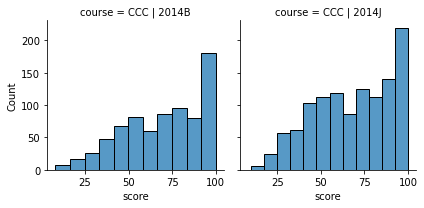

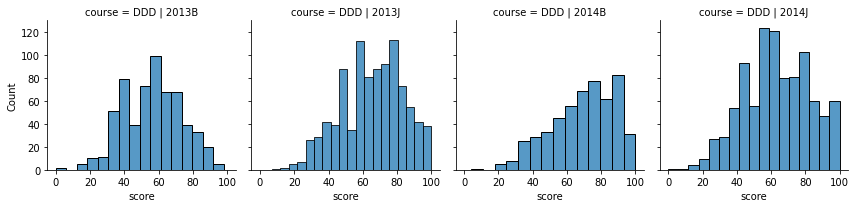

In [146]:
grapharray_1 = sns.FacetGrid(students_and_exams.query("code_module == 'CCC'"),
                             col = 'course',
                             col_order = ordered_courses[ordered_courses.str.startswith('CCC')])
grapharray_1.map(sns.histplot, 'score')

grapharray_2 = sns.FacetGrid(students_and_exams.query("code_module == 'DDD'"),
                             col = 'course',
                             col_order = ordered_courses[ordered_courses.str.startswith('DDD')])
grapharray_2.map(sns.histplot, 'score')

plt.show()

### Промежуточный вывод

Видна значительная разница в распределении оценок для модулей "CCC" и "DDD". Во втором случае распределение похоже на нормальное и хорошие баллы получает сравнительно мало учеников. В первом случае очень много отличников.

Соответственно, нужно выяснить, почему. Например:
- курс "CCC" сам по себе лёгкий,
- контрольные работы по курсу "CCC" сравнительно лёгкие
- на курсе "CCC" очень хорошее преподавание
- на курсе "DDD" стоит улучшить преподавание
- на курсе "DDD" излишне тяжёлый экзамен
- и т.д.

Нужны опросы среди всех прошедших эти курсы студентов. Вопросы стоит сформулировать для разных категорий (на которые мы разобъём дальше) отдельно.

Также стоит привлечь сторонних специалистов для проверки материалов и заданий курсов, чтобы осмотрели их "незамыленным" взглядом.

### Продолжение исследования

Получаем "граничные" значения, при помощи которых разделим студентов на две категории -- "отличники" и "успешно сдавшие экзамен". Те, у кого менее 40 баллов, автоматически попадают в третью категорию "не сдавшие экзамен":

In [147]:
course_DDD_medians = \
    students_and_exams.query("code_module == 'DDD'").groupby('course')['score'].median()

course_DDD_medians

course
DDD | 2013B    56.0
DDD | 2013J    67.0
DDD | 2014B    71.0
DDD | 2014J    62.0
Name: score, dtype: float64

Значение "отсечки" для предмета "DDD":

In [148]:
M_D = course_DDD_medians.mean()
M_D

64.0

In [149]:
course_CCC_means = \
    students_and_exams.query("code_module == 'CCC'").groupby('course')['score'].quantile(q = 0.75)

course_CCC_means

course
CCC | 2014B    90.0
CCC | 2014J    90.0
Name: score, dtype: float64

Значение "отсечки" для предмета "CCC":

In [150]:
M_C = course_CCC_means.mean()
M_C

90.0

M = M_c или M_D - соответствующее значение "отсечки".

Студент мог сдавать два (и, теоретически, больше) экзаменов -- тогда при нескольких полученных значениях категории выбирается наивысшая:

- категория 2: хотя бы один экзамен сдан на балл m &geq; M
- категория 1: хотя бы один экзамен сдан с баллом 40 ≤ m < M
- категория 0: m < 40 -- не сдал экзамен
- для не сдававших экзамен будет ```-1```

In [151]:
def set_category_M(code_module, score) :

    M = M_C if code_module == 'CCC' else M_D

    if score >= M :
        category = 2
    elif (score < M) and (score >= 40) :
        category = 1
    else :
        category = 0
        
    return category

Данные о студентах, сдавших экзамены, лежат в табличке ```students_and_exams_2``` (которая является немного модифицированной копией ```students_and_exams```):

In [152]:
students_and_exams['category_M'] = \
    students_and_exams.apply(lambda x: set_category_M(x.code_module, x.score), axis = 1)

In [153]:
students_category_M = students_and_exams.groupby('id_student').agg({'category_M': max}).reset_index()

Добавляем в [основную таблицу](#main_table) значения категорий для параметра ```M```:

In [154]:
students = students.merge(students_category_M,
                          on = 'id_student',
                          how = 'left')

students['category_M'] = students['category_M'].fillna(value = -1)

students['category_M'] = students['category_M'].astype(int)

In [155]:
students_performance_distribution = \
    students[['id_student', 'category_M']] \
    .drop_duplicates() \
    ['category_M'].value_counts() \
    .to_frame() \
    .reset_index() \
    .rename(columns = {'index': 'category_M', 'category_M': 'students'}) \
    .sort_values('category_M') \
    .reset_index(drop = True)

students_performance_distribution['students_pc'] = \
    round(100 * students_performance_distribution['students'] / students_total_number, 0)

students_performance_distribution

,category_M,students,students_pc
0,-1,24152,84.0
1,0,536,2.0
2,1,2117,7.0
3,2,1980,7.0


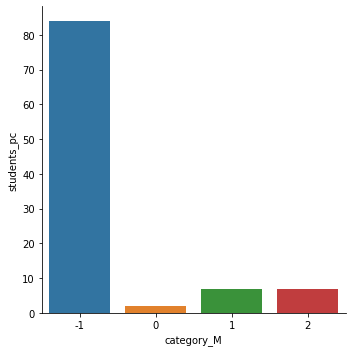

In [156]:
sns.catplot(data = students_performance_distribution,
            x = 'category_M',
            y = 'students_pc',
            kind = 'bar')
plt.show()

### Вывод

У нас получилось разбить сдавших экзамены студентов на три категории согласно их успеваемости - и с этими людьми можно отдельно работать --  как было уже сказано выше, их нужно опрашивать и получать обратную связь. Для тех, кто учился на обоих курсах -- в опроснике нужно сравнение двух курсов. Здесь поможет разбиение в категории ```F```. Категория ```M``` должна определять "вес" мнения -- прислушиваемся прежде всего к хорошистам и отличникам.


### Предложение

Однако таких людей всего 20% от всех студентов, остальные 80 % (ещё) не сдавали экзаменов. Предлагается по имеющимся 20 % выявить корреляцию между средней успеваемостью по сданным тестам и успешностью сдачи экзаменов -- то есть попаданием в ту или иную категорию.

## Определение параметров для разбиения по параметру ```F``` (завершаемость) <a class="anchor" id="cat_F"></a>

Для каждого студента просто производится подсчёт успешно сданных экзаменов -- полученная величина и определяет категорию.

**Завершаемость** будем категоризировать следующим образом:
- категория 0: студент пытался сдать экзамены но не сдал ни один
- категория 1: студент начал 1 или более курсов но завершил только один
- категория 2: студент начал и завершил два курса (или более -- хотя в наших данных максимум это два курса)
- для не сдававших экзамен будет ```-1``` (здесь будет много людей, которые учатся на потоках, где ещё не было экзаменов)

In [157]:
exams_passed = \
    students_and_exams \
    .groupby('id_student') \
    .agg({'is_exam_passed': 'sum'}) \
    .rename(columns = {'is_exam_passed': 'exams_passed'}) \
    .reset_index()

In [158]:
students = \
    students \
    .merge(exams_passed, on = 'id_student', how = 'left') \
    .rename(columns = {'exams_passed': 'category_F'})

students['category_F'] = students['category_F'].fillna(value = -1)

students['category_F'] = students['category_F'].astype(int)

По сдаче экзаменов для таких категорий параметра ```M``` как ```0```, ```1``` и ```2``` получаем тот же результат, что и при решении [задания 1](#task1):

In [159]:
exams_passed_distribution = \
    students[['id_student', 'category_F']] \
    .drop_duplicates() \
    ['category_F'].value_counts() \
    .to_frame() \
    .reset_index() \
    .rename(columns = {'index': 'category_F', 'category_F': 'students'}) \
    .sort_values('category_F') \
    .reset_index(drop = True)

exams_passed_distribution['students_pc'] = \
    round(100 * exams_passed_distribution['students'] / students_total_number, 0)

exams_passed_distribution

,category_F,students,students_pc
0,-1,24152,84.0
1,0,536,2.0
2,1,3802,13.0
3,2,295,1.0


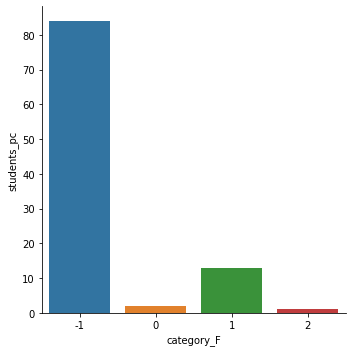

In [160]:
sns.catplot(data = exams_passed_distribution,
            x = 'category_F',
            y = 'students_pc',
            kind = 'bar')
plt.show()

## Определение параметров для разбиения по параметру ```R``` (среднее время сдачи одного экзамена) <a class="anchor" id="cat_R"></a>

Ранее, при решении [задания 3](#task3), мы получили величины средних сроков сдачи экзаменов:

In [161]:
dates_of_submission_mean.reset_index()

,code_module,code_presentation,date_submitted_mean
0,CCC,2014B,232.0
1,CCC,2014J,244.0
2,DDD,2013B,230.0
3,DDD,2013J,240.0
4,DDD,2014B,235.0
5,DDD,2014J,243.0


Предлагается следующие значения категорий:

- категория ```0```: студент ушёл со всех курсов, на которые записался, не сдал экзаменов -- здесь конкретно выделяются студенты, записывавшиеся на курсы, по которым производилась сдача экзаменов -- из таблицы выше
- категория ```1```: студент сдал все свои курсы за время, большее чем среднее время сдачи экзамена для данного курса
- категория ```2```: студент сдал хотя бы один из курсов за время, не превышающее среднее время сдачи экзамена для данного курса
- для не сдававших экзамен будет ```-1```

In [162]:
students_and_exams = \
    students_and_exams \
    .merge(dates_of_submission_mean.reset_index(), on = ['code_module', 'code_presentation'])

In [163]:
def set_category_R(date_submitted, date_submitted_mean) :

    if date_submitted >= date_submitted_mean :
        category = 1
    else :
        category = 2
        
    return category

In [164]:
students_and_exams['category_R'] = \
    students_and_exams\
    .apply(lambda x: set_category_R(x.date_submitted, x.date_submitted_mean),
           axis = 1)

In [165]:
students_and_exams = \
    students_and_exams \
    .drop('category_R', axis = 1) \
    .merge(students_and_exams.groupby('id_student', as_index = False).agg({'category_R': max}),
           on = 'id_student',
           how = 'left')

In [166]:
students_and_exams = \
    students_and_exams \
    [['id_student',
      'id_assessment',
      'code_module',
      'code_presentation',
      'course',
      'is_exam_passed',
      'score',
      'category_M',
      'date_submitted',
      'date_submitted_mean',
      'category_R']]

students_and_exams.drop(['code_module', 'code_presentation'], axis = 1).head()

,id_student,id_assessment,course,is_exam_passed,score,category_M,date_submitted,date_submitted_mean,category_R
0,23698,24299,CCC | 2014J,True,80.0,1,243,244.0,2
1,27116,24299,CCC | 2014J,True,96.0,2,243,244.0,2
2,28787,24299,CCC | 2014J,True,44.0,1,243,244.0,2
3,29420,24299,CCC | 2014J,True,62.0,1,244,244.0,1
4,29639,24299,CCC | 2014J,True,74.0,1,248,244.0,1


### Дополнительное исследование <a class="anchor" id="additional_research"></a>

Проверяем, есть ли такие студенты, которые дошли до сдачи экзамена и получили баллы, но ушли с курса:

In [167]:
# все студенты, которые ушли с курсов

studens_who_left_courses_and_tried_exams = \
    students[students['date_unregistration'].notna()] \
    [['id_student', 'code_module', 'code_presentation']] \
    .drop_duplicates() \
    .sort_values(['id_student', 'code_module', 'code_presentation'], ignore_index = True)

studens_who_left_courses_and_tried_exams['left_course'] = True

In [168]:
students_and_exams = \
    students_and_exams \
    .merge(studens_who_left_courses_and_tried_exams,
           how = 'left',
           on = ['id_student', 'code_module', 'code_presentation'])

students_and_exams['left_course'] = students_and_exams['left_course'].fillna(value = False)

# количество студентов, которые при этом сдали (успешно или неуспешно) экзамены:
students_and_exams['left_course'].sum()

1

Всего один человек. Остальные отсеялись на этапе промежуточных контрольных работ. Его ID:

In [169]:
students_and_exams[students_and_exams['left_course']]['id_student'].item()

425543

Как видим, решение он отправил быстро (на 237й день, при среднем 240):

In [170]:
students_and_exams[students_and_exams.id_student == 425543]

,id_student,id_assessment,code_module,code_presentation,course,is_exam_passed,score,category_M,date_submitted,date_submitted_mean,category_R,left_course
1879,425543,25354,DDD,2013J,DDD | 2013J,False,33.0,0,237,240.0,2,True


Экзамен он сдал плохо. При этом ушёл с курса на 232 день, ДО отправки им экзаменационного задания. Что очень странно. Возможно, ошибка в данных, и у него неправильно укзана дата ухода -- он, возможно, и не уходил с курса.

In [171]:
students.query("id_student == 425543")

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,date_registration,date_unregistration,course,category_M,category_F
81532,25348.0,425543,34.0,0.0,64.0,DDD,2013J,TMA,25.0,10.0,-39.0,232.0,DDD | 2013J,0,0
81533,25349.0,425543,54.0,0.0,56.0,DDD,2013J,TMA,53.0,12.5,-39.0,232.0,DDD | 2013J,0,0
81534,25350.0,425543,121.0,0.0,65.0,DDD,2013J,TMA,88.0,17.5,-39.0,232.0,DDD | 2013J,0,0
81535,25354.0,425543,237.0,0.0,33.0,DDD,2013J,Exam,261.0,100.0,-39.0,232.0,DDD | 2013J,0,0


### Промежуточный вывод

Cдававших экзамены мы распределили по категориям ```1``` и ```2``` параметра ```R```.

Осталось определить, есть ли те, кто попадает в категорию ```0```, и поместить всех оставшихся в категорию ```-1```.

Чтобы зачислить кого-то в категорию ```0```, нужно для курсов, по которым были экзамены (из таблички ```students_and_exams```), определить тех ребят, кто записался но не сдавал экзамен, ушёл раньше. Выше мы вычислили человека, который ушёл но при этом сдал экзамен. :-)

### Продолжаем разбивать по категориям

У нас есть результаты экзаменов по курсам ```CCC``` и ```DDD```:

In [172]:
courses_with_exams = \
    students_and_exams[['code_module', 'code_presentation', 'course']] \
    .drop_duplicates() \
    .sort_values(['code_module', 'code_presentation']) \
    .reset_index(drop = True)

courses_with_exams

,code_module,code_presentation,course
0,CCC,2014B,CCC | 2014B
1,CCC,2014J,CCC | 2014J
2,DDD,2013B,DDD | 2013B
3,DDD,2013J,DDD | 2013J
4,DDD,2014B,DDD | 2014B
5,DDD,2014J,DDD | 2014J


In [173]:
students = \
    students \
    .merge(students_and_exams[['id_student', 'category_R']].drop_duplicates(),
           on = 'id_student', how = 'left')

# students['category_R'] = \
#     students['category_R'].where(~students['category_R'].isna(),
#                                  other = students['category_F'])

students['category_R'] = \
    students['category_R'] \
    .where(~(students['course'].isin(courses_with_exams['course']) & students['category_R'].isna()),
           other = 0)  

students['category_R'] = students['category_R'].fillna(value = -1)

students['category_R'] = students['category_R'].astype(int)

In [174]:
timing_distribution = \
    students[['id_student', 'category_R']] \
    .drop_duplicates() \
    ['category_R'].value_counts() \
    .to_frame() \
    .reset_index() \
    .rename(columns = {'index': 'category_R', 'category_R': 'students'}) \
    .sort_values('category_R') \
    .reset_index(drop = True)

timing_distribution['students_pc'] = \
    round(100 * timing_distribution['students'] / students_total_number, 0)

timing_distribution

,category_R,students,students_pc
0,-1,20470,71.0
1,0,4770,17.0
2,1,2737,10.0
3,2,1896,7.0


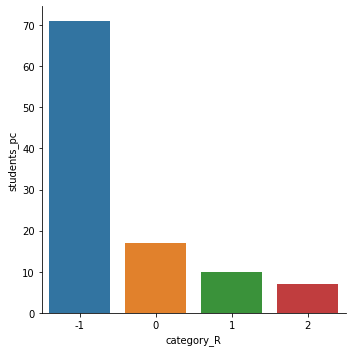

In [175]:
sns.catplot(data = timing_distribution,
            x = 'category_R',
            y = 'students_pc',
            kind = 'bar')
plt.show()

Здесь в категории ```0``` в 9 раз больше людей чем в такой же категории для параметров ```M``` и ```F``` (где число людей одинаково и равно ```536```) -- дело в том что для них в категорию ```0``` записывались все те, кто участвовал в эказаменах по предметам ```CCC``` и ```DDD```, но не сдал ни одного экзамена.

Проверим правильность выделения в категорию 0 -- туда должны попасть те, кто записался на рассматриваемые предметы, но *не сдал ни одной контрольной работы*.

Полное количество уникальных пользователей, записавшихся на курсы из ```courses_with_exams```:

In [176]:
students[students['course'].isin(courses_with_exams['course'])]['id_student'].nunique()

9403

Студенты, которые сдавали хоть какие-то контрольные работы:

In [177]:
students_who_tried_exams = \
    students_and_exams['id_student'] \
    .drop_duplicates() \
    .reset_index(drop = True)

In [178]:
students_who_tried_exams.shape[0]

# что эквивалентно
# students_and_exams['id_student'].nunique()

4633

<a class="anchor" id="students_who_left_courses"></a>
Люди, которые записывались на курсы из ```courses_with_exams```, но так и не сдали ни одной контрольной работы:

In [179]:
students[students['course'].isin(courses_with_exams['course'])]['id_student'].nunique() \
    - students_and_exams['id_student'].nunique()

4770

In [180]:
students_who_left_courses = \
    students[students['course'].isin(courses_with_exams['course']) \
         & (~students['id_student'].isin(students_who_tried_exams))] \
    ['id_student'] \
    .drop_duplicates() \
    .reset_index(drop = True)

students_who_left_courses.shape[0]

4770

Эти значения, вычисленные по разным таблицам, не только равны между собой, но и совпадают с числом людей в категории 0:
- мы не допустили ошибок при обработке таблиц ```students``` и ```students_and_exams```,
- мы правильно распределили людей в категорию ```0```.

## Результат <a class="anchor" id="result"></a>

В итоге, можно сформировать таблицу:

In [181]:
result = students[['id_student', 'category_R', 'category_F', 'category_M']] \
    .drop_duplicates().reset_index(drop = True)

которую и использовать для сегментированного подхода к разным категориям клиентов/студентов.

# Дополнительное исследование 2 <a class="anchor" id="additional_research2"></a>

При решении [задания 4](#task4) мы получили табличку ```courses_escapes``` для числа ушедших с курсов людей (без учёта повторных регистраций на один и тот же курс и уходов с него). Число уникальных пользователей, хотя бы раз покинувших курс:

In [182]:
courses_escapes.reset_index().query("code_module == 'CCC' | code_module == 'DDD'")['escapes'].sum()

4182

Полученное значение **НЕ** совпадает с числом 4770 -- количеством тех, кто не сдал ни одной контрольной работы. Это означает, что есть те, кто не ушёл с курса (так отображается в системе), хотя и не учился на нём.

Проверяем тех, кто попал в эту категорию -- они записывались на предмет ```CCC``` или ```DDD```:

In [183]:
tmp = students[students['category_R'] == 0] \
    .query("code_module == 'CCC' | code_module == 'DDD'")

Часть из них не прекращала регистрацию на курсе:

In [184]:
strange_students = \
    tmp[tmp['date_unregistration'].isna()] \
    [['id_student', 'course']].drop_duplicates() \
    .reset_index()

strange_students.shape[0]

1527

In [185]:
strange_students['id_student'].nunique()

1484

При этом никто из этой подгруппы в 1484 человека не находится в таблице сдававших экзамены ```students_and_exams```:

In [186]:
students_and_exams['id_student'].isin(strange_students['id_student']).sum()

0

Вторая подгруппа -- это те кто зарегистрировался на этих курсах, не сдавал никаких экзаменов, но при этом ушёл с курсов:

In [187]:
strange_students_2 = \
    tmp[~tmp['date_unregistration'].isna()] \
    [['id_student', 'course']].drop_duplicates() \
    .reset_index()

strange_students_2.shape[0]

3802

In [188]:
strange_students_2['id_student'].nunique()

3445

Из них также никто не участвовал в экзаменах.

Эти множества частично пересекаются:

In [189]:
strange_students['id_student'].isin(strange_students_2['id_student']).sum()

161

По предмету ```CCC``` видим, что часть людей (не прошедших курс) регистрировалась повторно:

In [190]:
tmp.query("code_module == 'CCC'") \
    [['id_student', 'course']] \
    .drop_duplicates() \
    .reset_index(drop = True) \
    .groupby('id_student', as_index = False) \
    .count() \
    ['course'].value_counts()

1    2046
2     102
Name: course, dtype: int64

По предмету ```DDD``` мы видим, что повторных регистраций (среди не прошедших курс) здесь в два раза больше, и даже есть те, кто регистрировался по 3 раза, а один человек сделал 4 попытки.

In [191]:
tmp.query("code_module == 'DDD'") \
    [['id_student', 'course']] \
    .drop_duplicates() \
    .reset_index(drop = True) \
    .groupby('id_student', as_index = False) \
    .count() \
    ['course'].value_counts()

1    2520
2     261
3      11
4       1
Name: course, dtype: int64

## Вывод

Имеет смысл отдельная проработка группы повторников. Возможно, для них нужен формат облегчённого курса. Или более лёгкие, предварительные курсы (как в плане подачи материалов, так и дедлайнов). предложения хороших скидок (если курсы были платными, а у людей не было денег).

# Дополнительное исследование 3 <a class="anchor" id="additional_research3"></a>

Как было предложено ранее, пронаблюдаем корреляцию между успеваемостью в течение курса и оценками на финальных экзаменах:

In [198]:
students_and_tests = \
    students[students['course'].isin(courses_with_exams['course']) \
             & (students['id_student'].isin(students_who_tried_exams)) \
             & (students['assessment_type'] != 'Exam')] \
    .dropna(subset = ['score']) \
    .groupby(['id_student', 'course'], as_index = False) \
    .agg({'score': 'mean'}) \
    .merge(students_and_exams[['id_student', 'course', 'score']] \
               .rename(columns = {'score': 'exam_score'}),
           on = ['id_student', 'course'])

students_and_tests['score'] = students_and_tests['score'].apply(lambda x: round(x, 1))

In [199]:
students_and_tests

,id_student,course,score,exam_score
0,23698,CCC | 2014J,73.8,80.0
1,24213,DDD | 2014B,79.3,58.0
2,27116,CCC | 2014J,93.0,96.0
3,28046,DDD | 2013J,51.0,40.0
4,28787,CCC | 2014J,56.0,44.0
...,...,...,...,...
4950,2694886,DDD | 2014B,70.7,69.0
4951,2694933,DDD | 2013B,75.3,73.0
4952,2695608,DDD | 2013J,80.5,73.0
4953,2697181,CCC | 2014B,89.2,80.0


Text(0, 0.5, 'Оценка на экзамене')

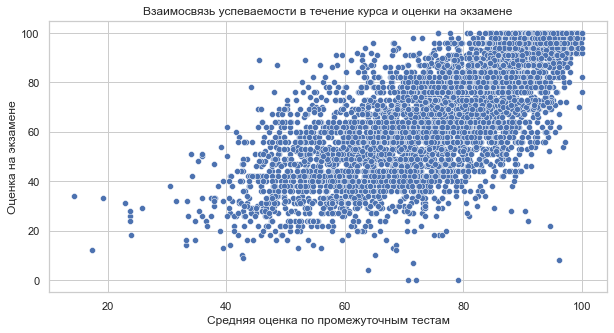

In [201]:
sns.set(style = 'whitegrid', rc = {'figure.figsize' : (10, 5)}) 
sns.scatterplot(x = 'score', y = 'exam_score', data = students_and_tests)
plt.title('Взаимосвязь успеваемости в течение курса и оценки на экзамене')
plt.xlabel('Средняя оценка по промежуточным тестам')
plt.ylabel('Оценка на экзамене')

Считаем коэффициент корреляции (Спирмана):

In [207]:
students_and_tests[['score', 'exam_score']].corr()

,score,exam_score
score,1.000000,0.703707
exam_score,0.703707,1.000000


Как мы видим, положительная связь есть, но не очень сильная, R сильно меньше 1.

В качестве эксперимента предлагается предварительно раскидать по категориям потоки студентов, ещё не сдавших экзамены по своим курсам. Категории обозначить, например, как ```10```, ```11```, ```12``` и т.д., т.е. вести разбиение аналогично тому как мы это делали для проэказменованных студентов, в названии категории указывая на различие между этими потоками (не прошедшими через экзамены, сидящих в категории ```-1```) и проэкзаменованными (которых мы раскидали по категориям ```0 - 2```).